In [1]:
import sys
import os
sys.path.insert(0, os.path.join('..', 'src'))
from network_laplacians import *
from data_management import *
from assign_network_parameters import *
import matplotlib.pyplot as plt

In [2]:
dimensions = 2  # Number of dimensions in the problem
number_joints = 4  # Number of joints in the network
L = 1  # Length parameter

#parameters for the network
caps_lam_2_list = np.logspace(-7, 7, 100)  # List of impedance values for diagonal rods ranging from 10^-7 to 10^7
tau_2 = 1  # Time constant tau_2
tau_1 = 1  # Time constant tau_1
caps_lam_1 = 1  # Impedance value for the rest of the rods in the square
u1 = 1  # Boundary condition, aplitude of oscillation at the input node at (0,0)

# Positions of the nodes in a 2D plane, square frame with a crossbar
node_positions = np.array([[0, 0], [L, 0], [0, L], [L, L]])
# Adjacency matrix representing the edges between nodes
edges = np.array([[0, 1, 1, 1], [1, 0, 0, 1], [1, 0, 0, 1], [1, 1, 1, 0]])

bc = [2, 3, 5]  # Boundary conditions: fixed coordinates, 2 corresponds to x coordinate and 3 corresponds to y coordinate of the node 2

w = 1  # Frequency of input oscillation

In [3]:
def compute():
    # Initialize a zero vector for P_til (Force) with size 2 * number_joints
    vect_P_til = np.zeros(2*number_joints)
     # Remove boundary condition indices from vect_P_til
    vect_P_til = np.delete(vect_P_til, bc)

    # To solve the equation DU = P_til, with some values of U known and some values of P_til known, we need to extract P2 from vect_P_til
    # and also extract the known values of U from U, and then solve for the unknown values of U.
    
    # Extract P2 from vect_P_til, excluding the first element
    P2 = vect_P_til[1:]
    
    # Initialize lists to store responses for Node 1 and Node 2
    Node_1_response =[]
    Node_2_response =[]

    # Loop over each impedance value for diagonal rod
    for caps_lam_2 in caps_lam_2_list:
        #tau_2 = caps_lam_2

        # Assign network parameters for the square network
        unit_vector_matrix,tau_matrix, capital_Lambda_matrix, unit_vector_matrix_reshaped = assign_square_network_one_lambda2(dimensions, number_joints, edges, node_positions, tau_1,tau_2,caps_lam_1, caps_lam_2)
        
        # Compute the Laplacian matrix for the truss network
        D_truss = laplacian_pure_elastic(dimensions, number_joints, edges,unit_vector_matrix, w, capital_Lambda_matrix, tau_matrix)
        
        #use below statement to compute the Laplacian matrix for the balls and springs network
        #D_spring = laplacian_balls_and_springs(dimensions, number_joints, edges,unit_vector_matrix, w, capital_Lambda_matrix, tau_matrix)
        
         # Remove boundary condition rows and columns from D_truss
        D_truss = np.delete(D_truss, bc, axis=0)
        D_truss = np.delete(D_truss, bc, axis=1)

        # Solving for the unknown values of U
        # Extract submatrices A22 and A21 from D_truss
        A22 = D_truss[1:,1:]
        A21 = D_truss[1:,0]

        # Compute the right-hand side of the equation
        A21u1 = P2 - np.dot(A21,u1)

        U2 = np.linalg.solve(A22,A21u1)

        # Insert u1 at the beginning of U2 to form u_til
        u_til = np.insert(U2, 0, u1)

        # Insert 0 at the boundary condition indices in u_til
        for ii in range(len(bc)):
            u_til = np.insert(u_til, bc[ii], 0)
        
        # Append the response of Node 1 and Node 2 to their respective lists
        Node_1_response.append(u_til[0]) #x-coordinate of source node, (0,0)
        l = len(u_til)
        Node_2_response.append(u_til[l-1]) #x-coordinate of target node, (L,L)

    return Node_1_response, Node_2_response

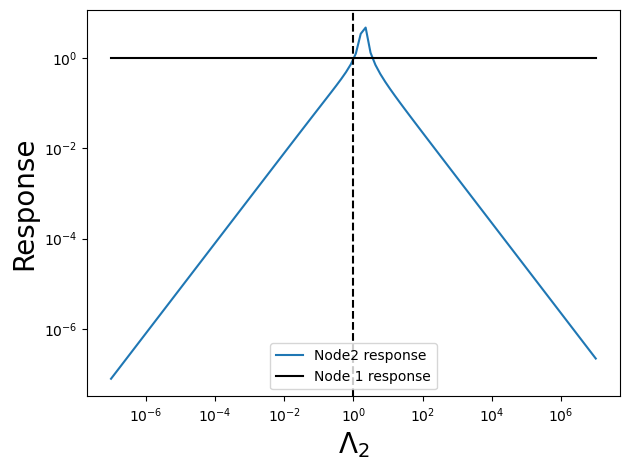

In [4]:
Node_1_response, Node_2_response =  compute() 
plt.plot(caps_lam_2_list, np.abs(Node_2_response),label='Node2 response')
plt.plot(caps_lam_2_list, np.abs(Node_1_response), color='k', label='Node 1 response')
plt.axvline(x=caps_lam_1, ls='--', color='k')
plt.xlabel(r'$\Lambda_2$', fontsize=20)

plt.ylabel('Response', fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.tight_layout()